In [1]:
#!pip install py_vollib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4.8, 3.2)
import os

from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings 
warnings.filterwarnings('ignore') #to suppress warning messages
np.set_printoptions(suppress=True)

In [2]:
# Import the two_factor quintic OU model
from two_factor_quintic_ou import TwoFactorQuinticOUModel  # Import the model class
from two_factor_quintic_ou import gen_bm_path  # generating gaussian iid
from two_factor_quintic_ou import vec_find_iv_rat   # compute implied volatility

In [3]:
# Model parameters stored in a dictionary
model_params = {
    'theta': 0.94,
    'rho': -0.769,
    'lamda_x': 35.2,
    'lamda_y': 0.623,
    'p_k': np.array([0.0004, 0.0038, 0.0004, 0.0085, 0.0005, 1]),
}

In [4]:
# Forward variance stored in a dictionary - interpolated using cubic spline
model_fvc = {'T_nodes': np.array([0.0001, 0.0005, 0.001 , 0.0015, 0.0055, 0.0303, 0.0552, 0.0801,
       0.105 , 0.1298, 0.1547, 0.1796, 0.2044, 0.2293, 0.2542, 0.2791,
       0.3039, 0.3288, 0.3537, 0.3785, 0.4034, 0.4283, 0.4531, 0.478 ,
       0.5029, 0.5278, 0.5526, 0.5775, 0.6024, 0.6272, 0.6521, 0.677 ,
       0.7019, 0.7267, 0.8857, 1.0447, 1.2036, 1.3626, 1.5216, 1.6805,
       1.8395, 1.9985, 2.1574]), 
         'int_var_nodes': np.array([0.00000023, 0.00000117, 0.00000235, 0.00000352, 0.00001286,
       0.00033119, 0.00052188, 0.00088383, 0.00126912, 0.0017979 ,
       0.00196599, 0.00270324, 0.00322654, 0.00332477, 0.00396569,
       0.00442826, 0.0048271 , 0.00615094, 0.00692078, 0.00707639,
       0.0076925 , 0.00881826, 0.00963305, 0.01002174, 0.01142226,
       0.01267608, 0.012891  , 0.013082  , 0.01361588, 0.0141797 ,
       0.01568081, 0.01668033, 0.01704239, 0.01780291, 0.02466145,
       0.03022112, 0.03537132, 0.04249715, 0.04841705, 0.05687464,
       0.0619833 , 0.06789834, 0.07726454])}

In [5]:
S_0 = 100.0
T_spx = 1/52
x1 = 0.0
x2 = 0.0

In [6]:
T_vix = 1/52
lm_vix = np.linspace(-0.1,1,40)
strike_perc_vix = np.exp(lm_vix)

lm = np.linspace(-0.2,0.03,40)
strikes = np.exp(lm)*S_0

In [7]:
model = TwoFactorQuinticOUModel(model_params, model_fvc)

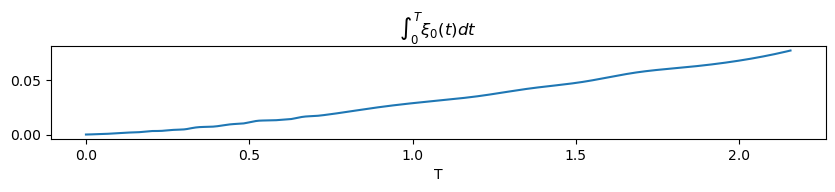

In [8]:
model.plot_fwd_int_var()

## Individual examples

#### VIX pricing

In [10]:
%%time
Ft_quant, opt_quant, vix_iv_quant = model.vix_pricing_quantization(T_vix,strike_perc_vix)

CPU times: total: 0 ns
Wall time: 2.82 ms


In [11]:
np.random.seed(42)
N_sims = 400000
Z_mc = gen_bm_path(2,N_sims)

In [12]:
%%time
(vix_Ft_mc, vix_opt_mc, vix_opt_mc_std,vix_iv_iv_mc,vix_iv_iv_mc_u,vix_iv_iv_mc_l) = \
model.vix_pricing_mc(T_vix,strike_perc_vix,Z_mc)

CPU times: total: 1 s
Wall time: 987 ms


#### SPX pricing

In [13]:
n_steps = 100
N_sims = 80000
w1 = gen_bm_path(n_steps,N_sims)

In [14]:
%%time
(spx_opt_mc, spx_opt_std, spx_iv_mc, spx_iv_u, spx_iv_l) =\
    model.spx_pricing_mc(x1,x2,S_0,T_spx,strikes,n_steps,N_sims,w1)

CPU times: total: 1.64 s
Wall time: 1.66 s


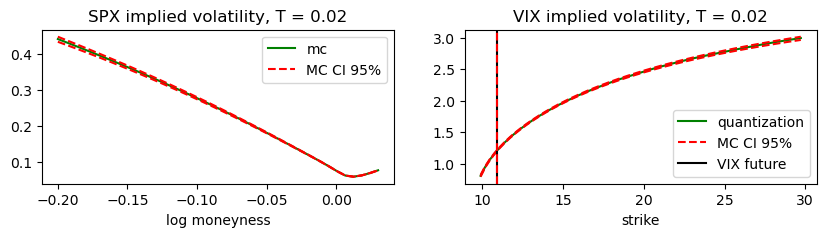

In [15]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.title(f'SPX implied volatility, T = {round(T_spx,2)}')
plt.plot(lm,spx_iv_mc,'g', label = 'mc')
plt.plot(lm,spx_iv_u,'--r', label = 'MC CI 95%')
plt.plot(lm,spx_iv_l,'--r')
plt.xlabel('log moneyness')
plt.legend()

plt.subplot(1,2,2)
plt.title(f'VIX implied volatility, T = {round(T_vix,2)}')
plt.plot(strike_perc_vix*Ft_quant,vix_iv_quant,'g', label = 'quantization')
plt.plot(strike_perc_vix*vix_Ft_mc,vix_iv_iv_mc_u,'--r', label = 'MC CI 95%')
plt.plot(strike_perc_vix*vix_Ft_mc,vix_iv_iv_mc_l,'--r')
plt.xlabel('strike')
plt.axvline(x = Ft_quant, color = 'black', label = 'VIX future')
plt.axvline(x = vix_Ft_mc, color = 'red', ls = '--')
plt.legend()
plt.show()

### SPX smiles

In [16]:
def spx_lm_range_rule(T_mat):
    ep_rule = 0.0001
    if T_mat<1/52:
        lm_range = [-0.1,0.03]
    elif T_mat<2/52:
        lm_range = [-0.15,0.03]
    elif T_mat <1/12:
        lm_range = [-0.25,0.03]
    elif T_mat < 2/12:
        lm_range = [-0.3,0.04]
    elif T_mat < 3/12:
        lm_range = [-0.4,0.08]
    elif T_mat < 6/12:
        lm_range = [-0.6,0.12]
    elif T_mat < 12/12:
        lm_range = [-0.8,0.15]
    else:
        lm_range = [-1.5,0.4]
    return lm_range

In [17]:
T_spx_array = np.array([0.03011636, 0.08213552, 0.183436  , 0.24093087, 0.42984257,
       0.64339493, 1.65913758, 2.15742642])
S_0 = 100.0

In [18]:
step_size_per_year = 252
total_n_steps = np.maximum(100,int(T_spx_array[-1]*step_size_per_year))
N_sims = 20000
np.random.seed(42)
w1_all=gen_bm_path(total_n_steps,N_sims)

In [19]:
strike_spx_array = []
for i in range(len(T_spx_array)):
    lm_temp = spx_lm_range_rule(T_spx_array[i])
    strike_spx_array.append(np.exp(np.linspace(lm_temp[0],lm_temp[1],50))*S_0)
strike_spx_array = np.array(strike_spx_array)
spx_iv_all = []
epochs_iter = tqdm(range(len(T_spx_array)), desc="iteration", miniters=1)
for i in epochs_iter:
    w1_temp = w1_all[:np.maximum(int(T_spx_array[i]*step_size_per_year),100)]
    n_steps = w1_temp.shape[0]
    (_, _, spx_iv_mc, _, _) = model.spx_pricing_mc(0.0,0.0,S_0,
                            T_spx_array[i],strike_spx_array[i],n_steps,N_sims,w1_temp)
    spx_iv_all.append(spx_iv_mc)
spx_iv_all = np.array(spx_iv_all)

iteration:   0%|          | 0/8 [00:00<?, ?it/s]

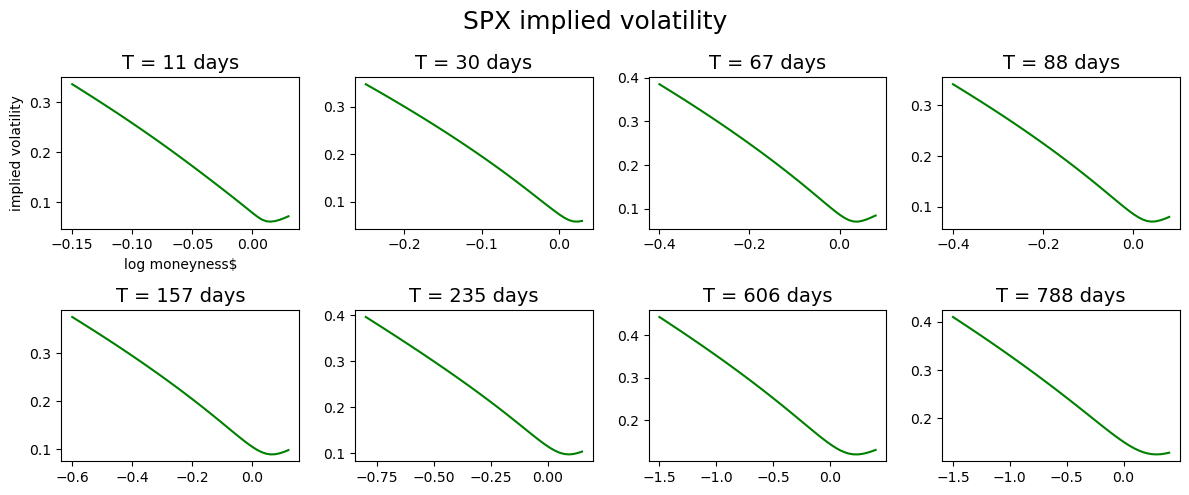

In [20]:
plt.figure(1,figsize=(12,5))
plt.suptitle('SPX implied volatility',fontsize=18)
for i in range(len(T_spx_array)):
    plt.subplot(2,4,i+1)
    if i ==0:
        plt.xlabel("log moneyness$",fontsize=10)
        plt.ylabel("implied volatility",fontsize=10)
    plt.title('T = {} days'.format(int(np.round(T_spx_array[i]*365.25,0))),fontsize=14)
    plt.plot(np.log(strike_spx_array[i]/S_0),spx_iv_all[i],'g')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### SPX skew stickiness ratio

In [21]:
T_ssr_array = np.array([1/52, 2/52, 1/12, 2/12, 3/12, 0.5,1,1.5,2])

In [22]:
spx_ssr_all = []
epochs_iter = tqdm(range(len(T_ssr_array)), desc="iteration", miniters=1)
for i in epochs_iter:
    w1_temp = w1_all[:np.maximum(int(T_ssr_array[i]*step_size_per_year),100)]
    n_steps = w1_temp.shape[0]
    spx_ssr_all.append(model.spx_ssr_mc(T_ssr_array[i],n_steps,N_sims,w1_temp))
spx_ssr_all = np.array(spx_ssr_all)

iteration:   0%|          | 0/9 [00:00<?, ?it/s]

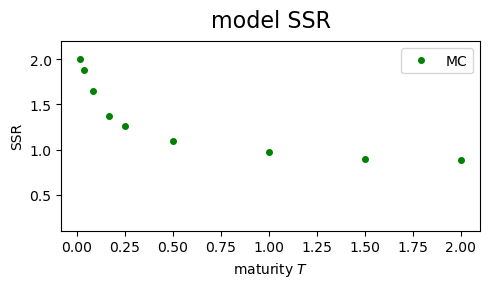

In [23]:
plt.figure(figsize=(5, 3))
plt.title("model SSR", size=16, y = 1.03)
plt.plot(T_ssr_array, spx_ssr_all, marker = "o",ls = '', color = 'green', ms=4, label="MC")
plt.xlabel(r"maturity $T$", fontsize = 10)
plt.ylabel("SSR", fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(fontsize = 10)
plt.ylim(0.1, 2.2)
plt.tight_layout()
plt.show()

### VIX smiles

In [24]:
T_vix_array = np.array([0.02464066, 0.06297057, 0.08213552, 0.15879535, 0.31211499,
       0.48459959])

In [25]:
strike_perc_vix_mins = np.array([0.94400028, 0.94124471, 0.92359907, 0.92696926, 0.91523008,
       0.91033437])
strike_perc_vix_maxs = np.array([1.91484922, 3.0199973 , 2.53358801, 4.04629642, 4.93758055,
       4.55585014])
strike_perc_vix_array = []
for i in range(len(T_vix_array)):
    strike_perc_vix_array.append(np.linspace(strike_perc_vix_mins[0],strike_perc_vix_maxs[1],50))
strike_perc_vix_array = np.array(strike_perc_vix_array)
vix_fut_all = []
vix_iv_all = []
epochs_iter = tqdm(range(len(T_vix_array)), desc="iteration", miniters=2)
for i in epochs_iter:
    vix_fut_temp, _, vix_iv_temp = model.vix_pricing_quantization(T_vix_array[i],strike_perc_vix_array[i])
    vix_fut_all.append(vix_fut_temp)
    vix_iv_all.append(vix_iv_temp)
vix_fut_all = np.array(vix_fut_all)
vix_iv_all = np.array(vix_iv_all)

iteration:   0%|          | 0/6 [00:00<?, ?it/s]

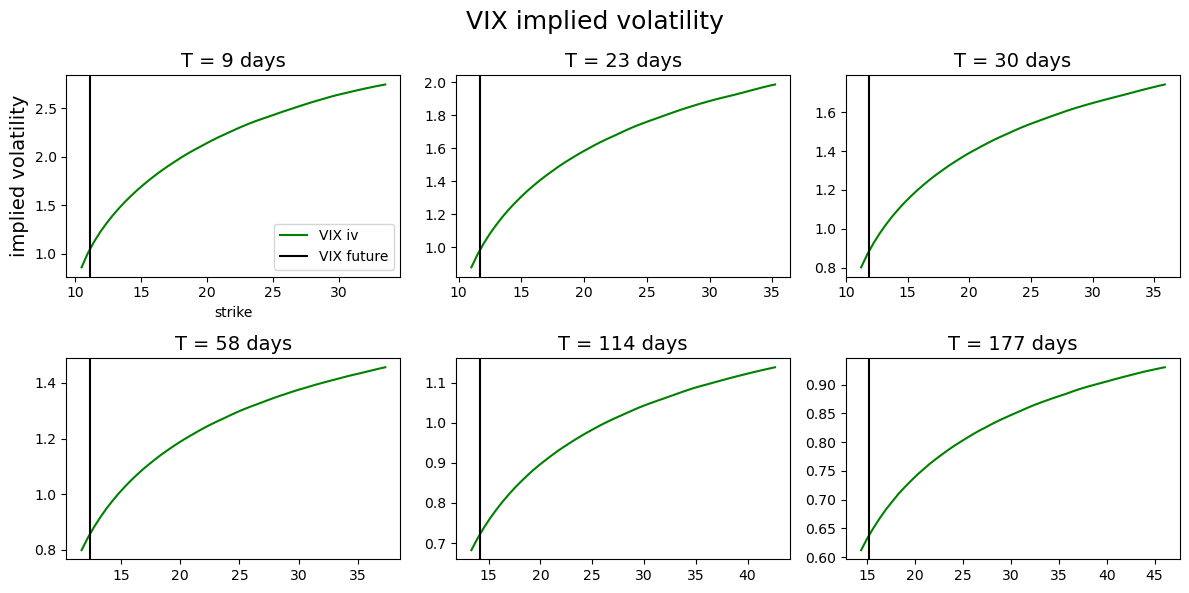

In [26]:
plt.figure(1,figsize=(12,6))
counter=1
plt.suptitle('VIX implied volatility',fontsize=18)
for i in range(len(T_vix_array)):
    plt.subplot(2,3,i+1)
    plt.title('T = {} days'.format(int(np.round(T_vix_array[i]*365.25,0))),fontsize=14)
    plt.plot(strike_perc_vix_array[i]*vix_fut_all[i],vix_iv_all[i],'g', label = 'VIX iv')
    plt.axvline(x = vix_fut_all[i], ls='-',color = 'black', label = 'VIX future')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    if i ==0:
        plt.xlabel("strike",fontsize=10)
        plt.ylabel("implied volatility",fontsize=14)
        plt.legend()
plt.tight_layout()
plt.show()